# Optimizing windows for satellite data 
### Brian Mapes Nov 20222

In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [1]:
#from IPython.display import Video
#Video("DATA/closedcellday_2022_09_06.mp4", embed=True)
# Open in browser: 
# file:///Users/brianmapes/Github/stratocu_waves/DATA/closedcellday_2022_09_06.mp4

In [2]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [3]:
# import pyprocess # My version in local directory

In [4]:
frame_a  = tools.imread( 'DATA/image_0_2022_09_06_15_15_00Z.png' ) #[:,-1024:] # Make square 1024x1024
frame_b  = tools.imread( 'DATA/image_1_2022_09_06_15_45_00Z.png' ) #[:,-1024:]

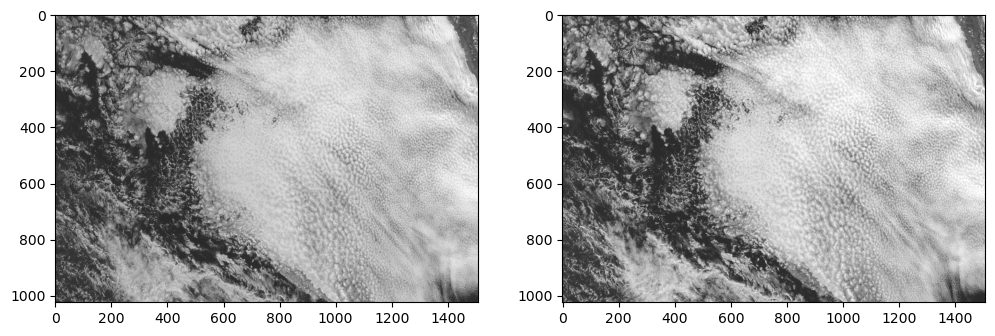

In [29]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray, clim=[0,200])
ax[1].imshow(frame_b,cmap=plt.cm.gray, clim=[0,200])

In [6]:
winsize = 36 # pixels, interrogation window size in frame A
searchsize = 36  # pixels, search in image B big enough to contain credible velocity 
overlap = 18 # pixels, 50% overlap if half of winsize
dt = 1 # time interval between images, converts pixel displacement to velocity

# Coordinates of velocity positions in image array
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [7]:
u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2mean')
# return u/dt, v/dt, sig2noise

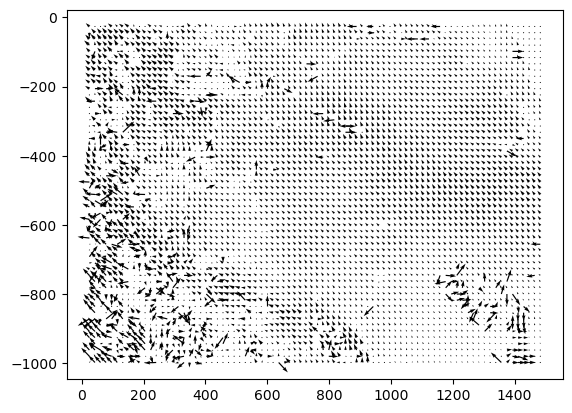

In [8]:
plt.quiver(x,-y, u,-v)

In [9]:
# Two passes of outlier removal 
u, v, mask = validation.global_std(u, v, std_threshold=3)
u, v, mask = validation.global_std(u, v, std_threshold=3)

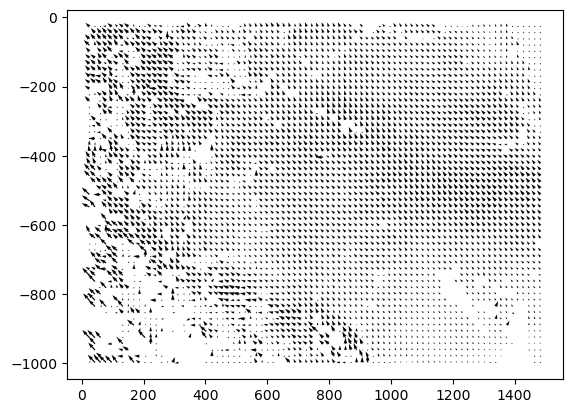

In [10]:
plt.quiver(x,-y, u,-v)

In [11]:
# Fill gaps a bit, once or twice
u, v = filters.replace_outliers( u, v, 
                                  method='localmean', 
                                  max_iter=7, 
                                  kernel_size=7)

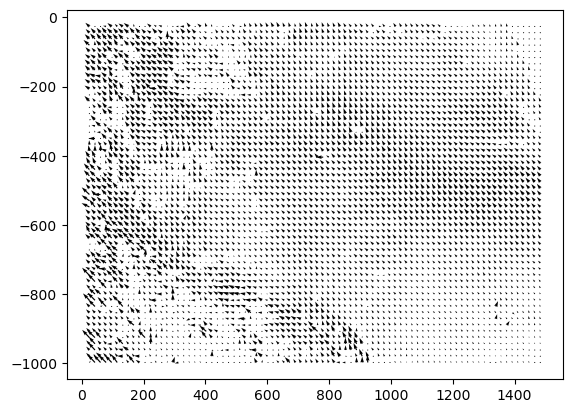

In [12]:
plt.quiver(x,-y, u,-v)

In [13]:
#save in the simple ASCII table format
# image coords to xy coords: 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u, v = tools.transform_coordinates(x, y, u, v)

tools.save(x, y, u, v, mask, 'exp1_001.txt' )

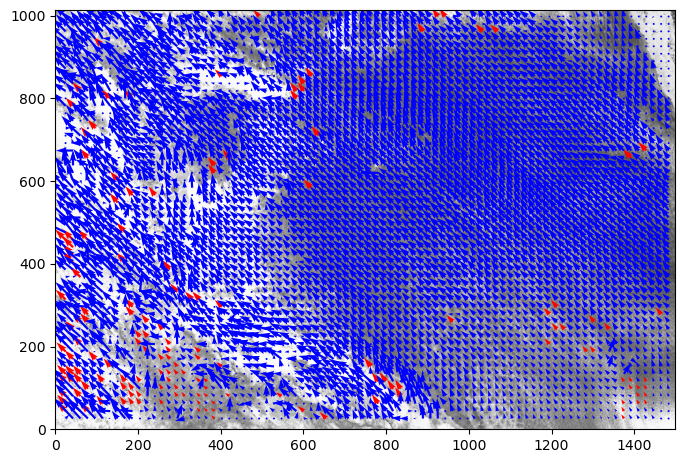

In [14]:
# Display from that file 
fig, ax = plt.subplots(figsize=(8,10))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, 
                           scale=300, # scale defines here the arrow length, but inversely
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the first image
                           image_name='DATA/image_0_2022_09_06_15_15_00Z.png');

In [15]:
from scipy.ndimage import gaussian_filter as smoo

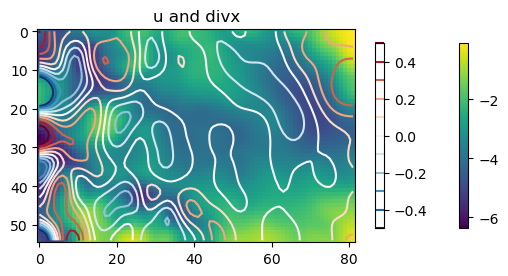

In [16]:
#du/dx divergence component 
plt.imshow(smoo(u,2)); plt.colorbar(shrink=0.5)
plt.title('u and divx')
divx = np.gradient(u)[1]
plt.contour(smoo(divx,3), cmap='RdBu_r', levels= (-5+np.arange(11))/10. ); plt.colorbar(shrink=0.5)

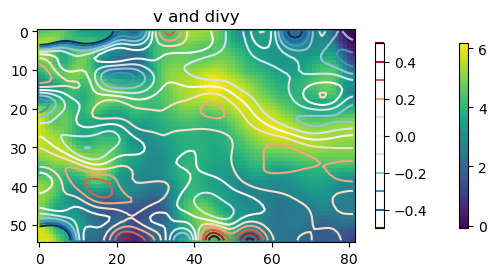

In [17]:
#dv/dy divergence component 
plt.imshow(smoo(v,2)); plt.colorbar(shrink=0.5)
plt.title('v and divy')
divy = -np.gradient(v)[0]
plt.contour(smoo(divy,3), cmap='RdBu_r', levels= (-5+np.arange(11))/10. ); plt.colorbar(shrink=0.5)

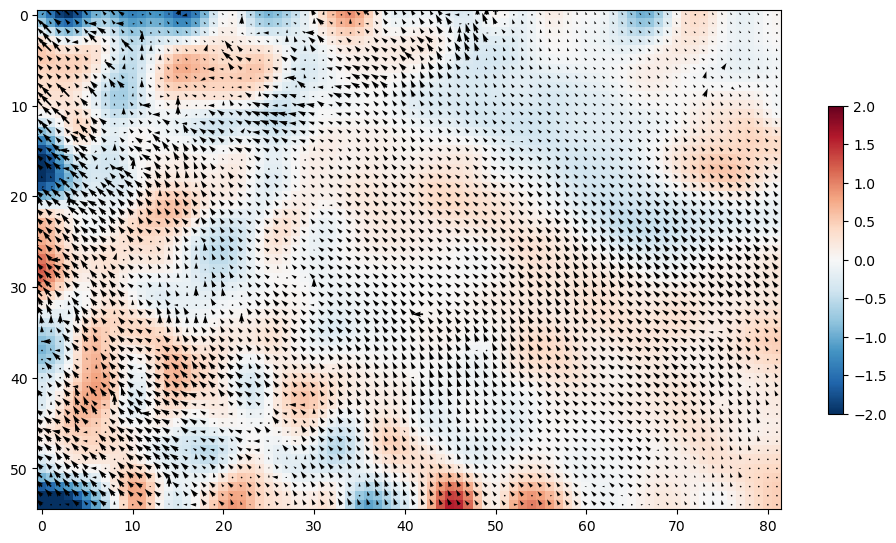

In [18]:
div = divx+divy # confirmed visually above! 

fig,ax = plt.subplots(figsize=(12,8))

plt.imshow(smoo(div, 2), cmap='RdBu_r'); 
plt.clim([-2,2]); plt.colorbar(shrink=0.5)

plt.quiver( (x-x.min()) /winsize*2, (y-y.min()) /winsize*2, u,v)

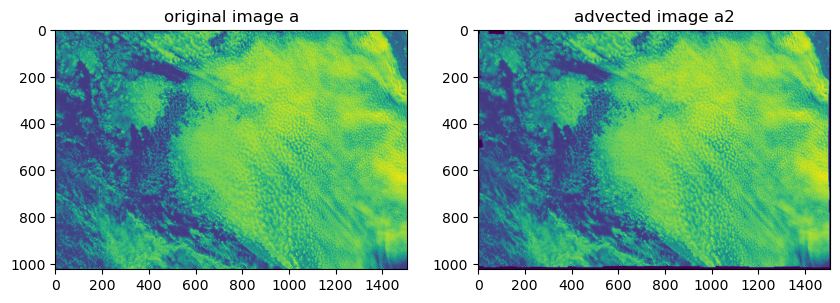

In [19]:
# A loop, god help me, inelegant but it's clear. Build a2 as an average 

# sum/num will be the average, just remember to avoid zero division
a2sum = frame_a.copy()*0.0
a2num = frame_a.copy()*0

# u and v offsets in nearest pixel, integer
xi = x.round().astype(int).ravel()
yi = y.round().astype(int).ravel()
ui = u.round().astype(int).ravel()
vi = v.round().astype(int).ravel()


# Loop over all the little windows in a and add them into a2 
for idx,vpoint in enumerate(xi.ravel()):
    windowa = (slice(yi[idx]-winsize//2, yi[idx]+winsize//2,1), 
               slice(xi[idx]-winsize//2, xi[idx]+winsize//2,1) ) # source image

    windowa2= (slice(yi[idx]-winsize//2 + -vi[idx], 
                     yi[idx]+winsize//2 + -vi[idx],1), 
               slice(xi[idx]-winsize//2 + ui[idx], 
                     xi[idx]+winsize//2 + ui[idx],1) ) # where to put it
    
    try: 
        a2sum[windowa2] += frame_a[windowa]
        a2num[windowa2] += 1
    except: 
        continue
        
a2 = (a2sum/(a2num 
             +0.000001)) # avoid division by zero

plt.figure(figsize=[10,5])
plt.subplot(1, 2, 1)
plt.imshow(frame_a); plt.title('original image a'); plt.clim(0,200)
plt.subplot(1, 2, 2)
plt.imshow(a2); plt.title('advected image a2'); plt.clim(0,200)

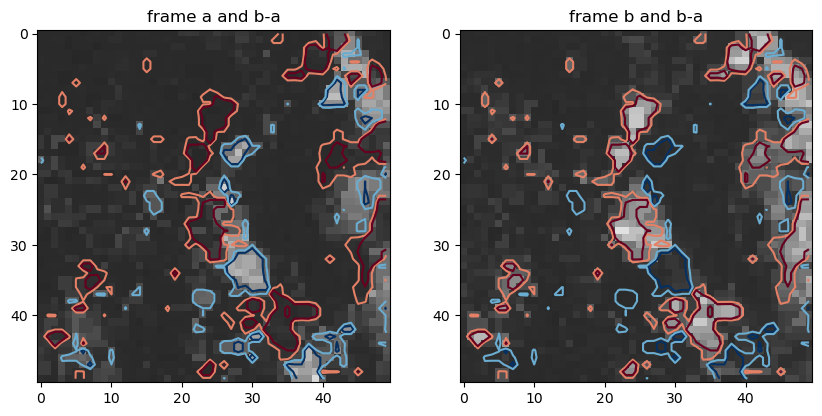

In [23]:
# Difference is mostly advection (+/- downwind dipoles)

box = (slice(500,550,1), slice(350,400,1) )

plt.figure(figsize=[10,5])

plt.subplot(1, 2, 1)
plt.imshow(frame_a[box],cmap=plt.cm.gray); plt.title('frame a and b-a'); plt.clim(0,200)
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 2, 2)
plt.imshow(frame_b[box],cmap=plt.cm.gray); plt.title('frame b and b-a'); plt.clim(0,200)
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

# plt.colorbar()

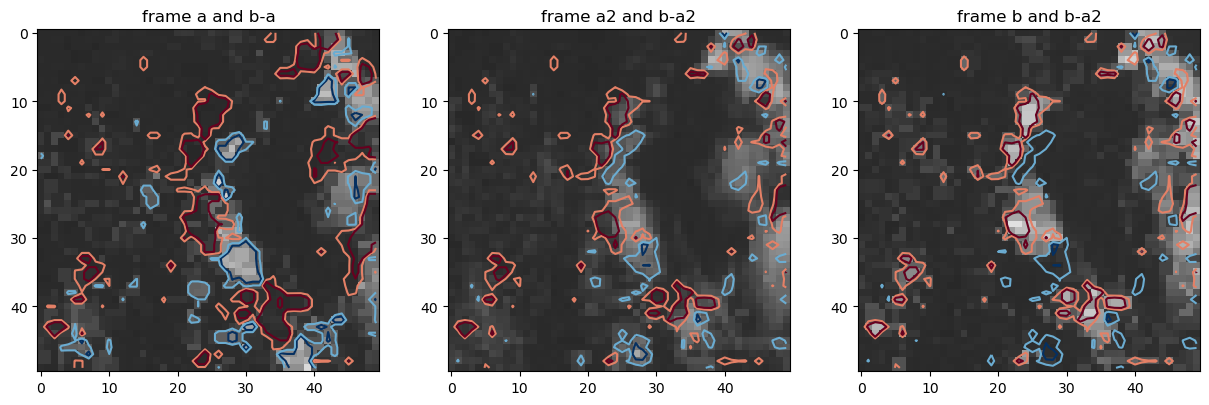

In [24]:
box = (slice(500,550,1), slice(350,400,1) )

plt.figure(figsize=[15,5])

plt.subplot(1, 3, 1)
plt.imshow(frame_a[box],cmap=plt.cm.gray); plt.title('frame a and b-a'); plt.clim(0,200)
#plt.contour((a2-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 3, 2)
plt.imshow(a2[box],cmap=plt.cm.gray); plt.title('frame a2 and b-a2'); plt.clim(0,200)
plt.contour((frame_b-a2)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
#plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

plt.subplot(1, 3, 3)
plt.imshow(frame_b[box],cmap=plt.cm.gray); plt.title('frame b and b-a2'); plt.clim(0,200)
plt.contour((frame_b-a2)[box],levels=[-50,-25,25,50], cmap='RdBu_r')
#plt.contour((frame_b-frame_a)[box],levels=[-50,-25,25,50], cmap='RdBu_r')

# plt.colorbar()

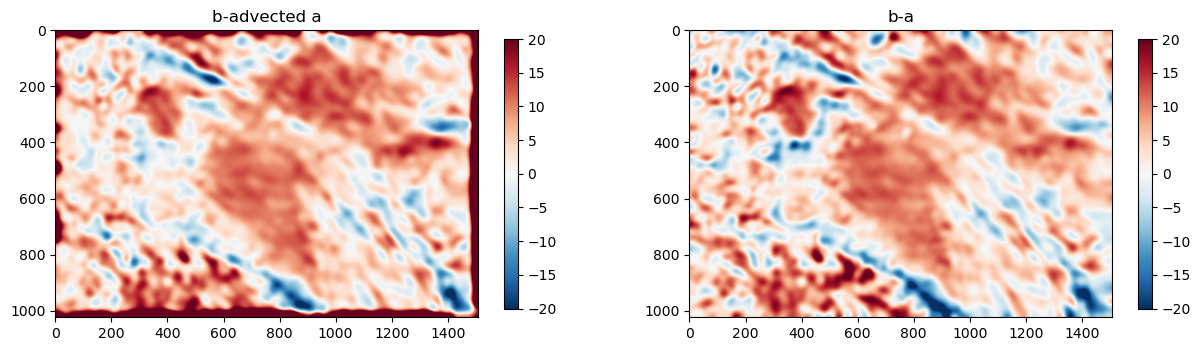

In [25]:
# waves 
plt.figure(figsize=[15,5])

plt.subplot(1, 2, 1)
plt.imshow(smoo(frame_b-a2, 13), cmap='RdBu_r')
plt.clim(-20,20)
plt.title('b-advected a')
plt.colorbar(shrink=0.7)

plt.subplot(1, 2, 2)
plt.imshow(smoo(frame_b-frame_a, 13), cmap='RdBu_r')
plt.clim(-20,20)
plt.title('b-a')
plt.colorbar(shrink=0.7)

In [26]:
# functions for constructing wavenumber and angle, for filtering masks 
def distance_from(a, index):
    i,j = np.indices(a.shape, sparse=True)
    return np.sqrt((i-index[0])**2 + (j-index[1])**2)
def angle_from(a, index):
    i,j = np.indices(a.shape, sparse=True)
    return np.arctan2((j-index[1]),(i-index[0]))

Text(0.5, 1.0, 'log power')

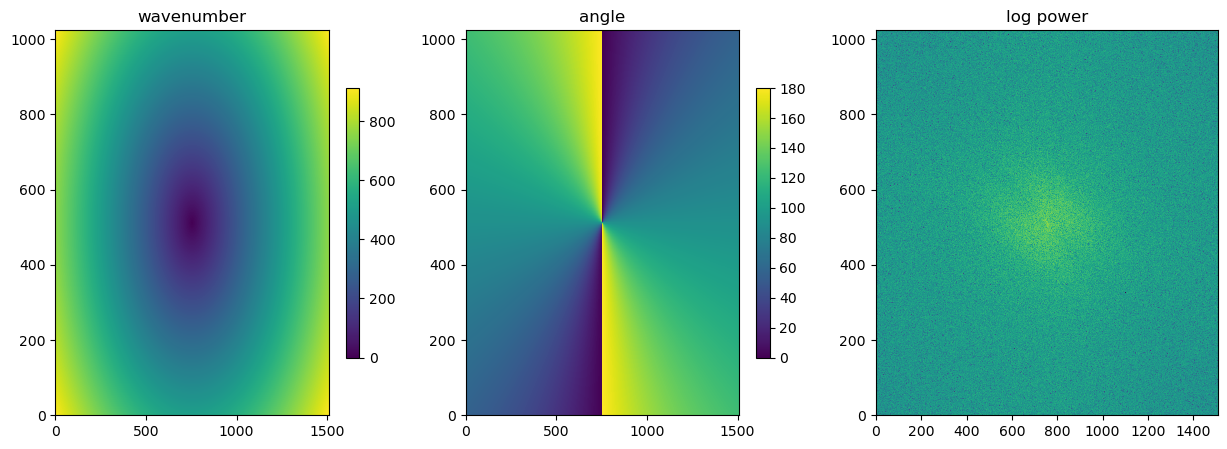

In [30]:
# Fourier transform and shift to center and total wavenumber array kl
diff = frame_b-frame_a
diffhat = np.fft.fftshift(np.fft.fft2(diff))

# Power
power = np.abs(diffhat)**2

# Wavenumbers 
kl = distance_from(diffhat, [diffhat.shape[0]/2, diffhat.shape[1]/2] )

# Angles are redundant SW-NE or NW-SE 
rose = angle_from(diffhat, [diffhat.shape[0]/2, diffhat.shape[1]/2] )
centerline = rose.shape[1]//2
rose[:,0:centerline] = np.flipud(np.fliplr( rose[:,centerline:] ))  
rose *= 180./np.pi # degrees

# Show the spectrum and spectral coordinates 
plt.figure(figsize=[15,5])
plt.subplot(1, 3, 1)
plt.pcolormesh(kl); plt.title('wavenumber'); plt.colorbar(shrink=0.7)
plt.subplot(1, 3, 2)
plt.pcolormesh(rose); plt.title('angle'); plt.colorbar(shrink=0.7)
plt.subplot(1, 3, 3)
plt.pcolormesh(np.log(power)); plt.title('log power')

Text(0.5, 1.0, 'filtered d/dt(brightness)')

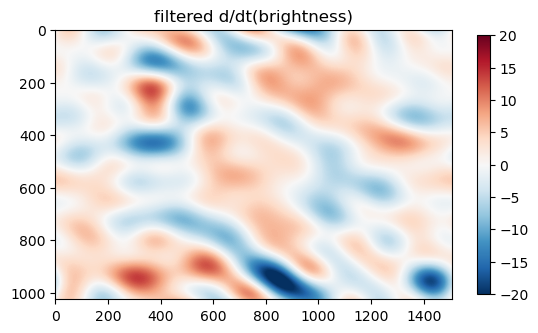

In [55]:
# Filter and reconstruct 
mask = (  (kl>1) & (kl<=8) )  #& ( (rose<10) | (rose>170) )   )
        
recon = np.fft.ifft2( np.fft.ifftshift( diffhat*mask ))

plt.imshow(recon.real, cmap='RdBu_r')
plt.clim(-20,20); plt.colorbar(shrink=0.7); plt.title('filtered d/dt(brightness)')

Text(0.5, 1.0, 'convergence of PIV velocities')

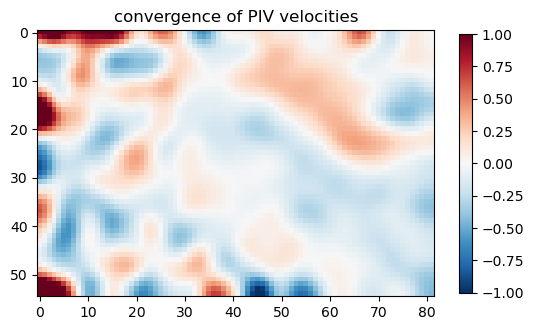

In [56]:
# Does it match divergence of the PIV winds? 
plt.imshow(smoo(-div, 2.5), cmap='RdBu_r', clim=[-1,1]); plt.colorbar(shrink=0.7)
plt.title('convergence of PIV velocities')

In [41]:
# Spectral grouping and binning and averaging 

In [32]:
import pandas as pd

In [33]:
# Take some relevant values, low wavenmubers, into a dataframe for groupby

mask = (  (kl>1) & (kl<30) )
df = pd.DataFrame([power[mask].ravel(),kl[mask].ravel(),rose[mask].ravel()], 
                  ['P','k','angle']).transpose()

In [34]:
df

P          k      angle
0     3.763831e+10  29.832868  12.094757
1     1.094873e+10  29.614186  10.124672
2     2.255900e+10  29.427878   8.130102
3     7.558511e+09  29.274562   6.115504
4     1.983252e+11  29.154759   4.085617
...            ...        ...        ...
2799  1.983252e+11  29.154759   5.906141
2800  7.558511e+09  29.274562   7.853313
2801  2.255900e+10  29.427878   9.782407
2802  1.094873e+10  29.614186  11.689369
2803  3.763831e+10  29.832868  13.570434

[2804 rows x 3 columns]

<AxesSubplot: xlabel='k'>

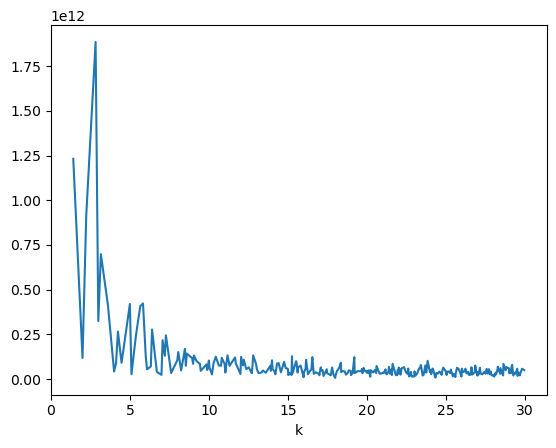

In [35]:
# Power spectrum 
df.groupby(df.k).mean().P.plot()

In [36]:
ANS = df.groupby([df.k,df.angle]).mean()

In [37]:
ANS

P
k         angle                   
1.414214  0.000000    1.325471e+12
          45.000000   1.325471e+12
          135.000000  1.137666e+12
          180.000000  1.137666e+12
2.000000  0.000000    1.716903e+11
...                            ...
29.966648 65.224859   5.510620e+10
          115.709954  6.311273e+10
          118.300756  6.311273e+10
          154.290046  3.478419e+10
          156.801409  3.478419e+10

[2764 rows x 1 columns]